# Sentiment Analysis - Hotstar Reviews

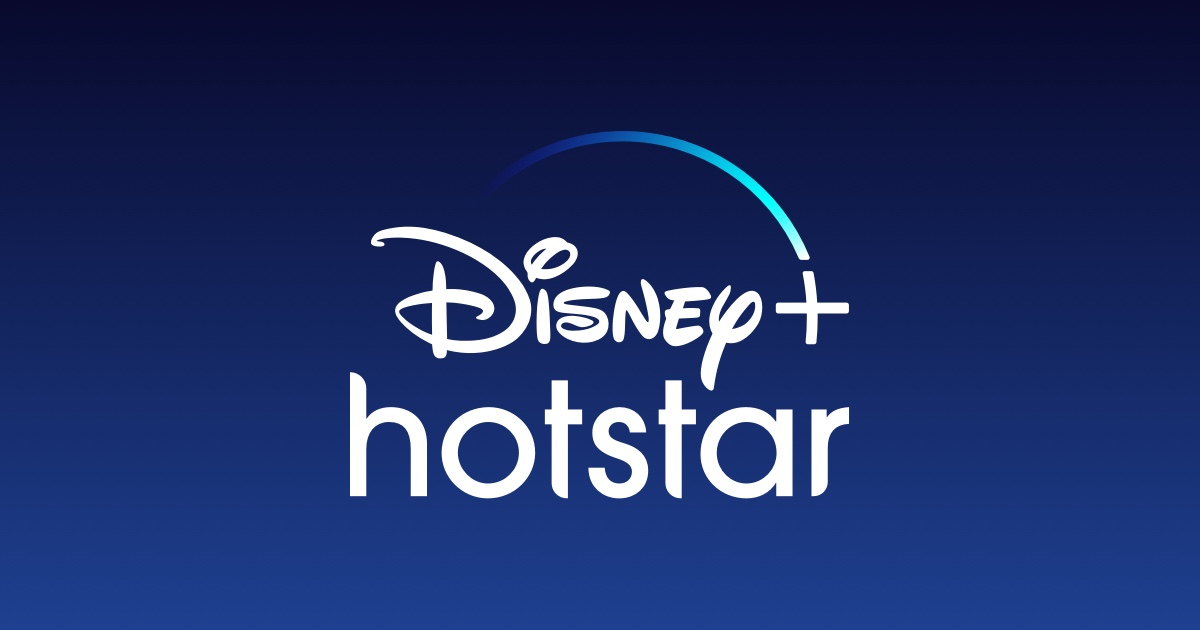

## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import nltk
from nltk import corpus, tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib

## Loading the data

In [2]:
data = pd.read_csv("hotstar_reviews.csv")
data.head()

,ID,UserName,Created_Date,Reviews,Lower_Case_Reviews,Sentiment_Manual_BP,Sentiment_Manual,Review_Length,DataSource,Year,Month,Date,Sentiment_Polarity
0,1,NaN,08-10-2017,Hh,hh,Negative,Negative,2,Google_PlayStore,2017,8,10,Neutral
1,2,NaN,08-11-2017,No,no,Negative,Negative,2,Google_PlayStore,2017,8,11,Neutral
2,3,asadynwa,08-12-2017,@hotstar_helps during paymnt for premium subsc...,@hotstar_helps during paymnt for premium subsc...,Help,Negative,140,Twitter,2017,8,12,Negative
3,4,jineshroxx,08-11-2017,@hotstartweets I am currently on Jio network a...,@hotstartweets i am currently on jio network a...,Help,Negative,140,Twitter,2017,8,11,Positive
4,5,YaminiSachar,08-05-2017,@hotstartweets the episodes of Sarabhai vs Sar...,@hotstartweets the episodes of sarabhai vs sar...,Help,Negative,140,Twitter,2017,8,5,Neutral


## Removing unwanted features
#### 1. Since ID, UserName, Created_Date are not relevant removing these columns.
#### 2. Since lower_Case_Reviews is the reviews in lower case, removing reviews column.

In [3]:
df = data.iloc[:,4:]
df.head()

,Lower_Case_Reviews,Sentiment_Manual_BP,Sentiment_Manual,Review_Length,DataSource,Year,Month,Date,Sentiment_Polarity
0,hh,Negative,Negative,2,Google_PlayStore,2017,8,10,Neutral
1,no,Negative,Negative,2,Google_PlayStore,2017,8,11,Neutral
2,@hotstar_helps during paymnt for premium subsc...,Help,Negative,140,Twitter,2017,8,12,Negative
3,@hotstartweets i am currently on jio network a...,Help,Negative,140,Twitter,2017,8,11,Positive
4,@hotstartweets the episodes of sarabhai vs sar...,Help,Negative,140,Twitter,2017,8,5,Neutral


In [4]:
df.tail()

,Lower_Case_Reviews,Sentiment_Manual_BP,Sentiment_Manual,Review_Length,DataSource,Year,Month,Date,Sentiment_Polarity
5048,i loathe this application in so many levels fo...,Negative,Negative,423,Google_PlayStore,2017,8,12,Negative
5049,1 cannot keep track of progress if you watch v...,Negative,Negative,479,Google_PlayStore,2017,8,11,Neutral
5050,1 miles below experience like amazon prime 2 e...,Negative,Negative,543,Google_PlayStore,2017,8,9,Neutral
5051,you pay for premium your internet speed is at ...,Negative,Negative,565,Google_PlayStore,2017,8,10,Positive
5052,very very frustrating navigation this applicat...,Negative,Negative,586,Google_PlayStore,2017,8,9,Neutral


## Removing "@some_name" and "#some_name"
#### 1. @ is used to mention some person following with actual comment so removing "@some_name" it from reviews
#### 2. # is used to tag some trend after actual comment so removing the "#some_name" from reviews

In [5]:
def extract_comment(comment):
    """ Returns comment after removing '@some_name' and '#some_name'"""
    mention_pattern = r"@[\w_]+"
    hashtag_pattern = r"#[\w_]+"
    result = re.sub(mention_pattern, "", comment)
    result = re.sub(hashtag_pattern, "", result)
    return result

In [6]:
df['reviews'] = df['Lower_Case_Reviews'].apply(extract_comment)

In [7]:
df['reviews']

0                                                      hh
1                                                      no
2        during paymnt for premium subscription the tr...
3        i am currently on jio network and would like ...
4        the episodes of sarabhai vs sarabhai season 1...
                              ...                        
5048    i loathe this application in so many levels fo...
5049    1 cannot keep track of progress if you watch v...
5050    1 miles below experience like amazon prime 2 e...
5051    you pay for premium your internet speed is at ...
5052    very very frustrating navigation this applicat...
Name: reviews, Length: 5053, dtype: object

In [8]:
df.drop("Lower_Case_Reviews", axis=1, inplace=True)

In [9]:
df.head()

,Sentiment_Manual_BP,Sentiment_Manual,Review_Length,DataSource,Year,Month,Date,Sentiment_Polarity,reviews
0,Negative,Negative,2,Google_PlayStore,2017,8,10,Neutral,hh
1,Negative,Negative,2,Google_PlayStore,2017,8,11,Neutral,no
2,Help,Negative,140,Twitter,2017,8,12,Negative,during paymnt for premium subscription the tr...
3,Help,Negative,140,Twitter,2017,8,11,Positive,i am currently on jio network and would like ...
4,Help,Negative,140,Twitter,2017,8,5,Neutral,the episodes of sarabhai vs sarabhai season 1...


## Recalculating review length
#### Since we removed '@some_name' and '#some_name' from reviews, the length of review will we changed

In [10]:
df['Review_Length'] = df['reviews'].apply(lambda x: len(x))

In [11]:
df.head()

,Sentiment_Manual_BP,Sentiment_Manual,Review_Length,DataSource,Year,Month,Date,Sentiment_Polarity,reviews
0,Negative,Negative,2,Google_PlayStore,2017,8,10,Neutral,hh
1,Negative,Negative,2,Google_PlayStore,2017,8,11,Neutral,no
2,Help,Negative,126,Twitter,2017,8,12,Negative,during paymnt for premium subscription the tr...
3,Help,Negative,126,Twitter,2017,8,11,Positive,i am currently on jio network and would like ...
4,Help,Negative,126,Twitter,2017,8,5,Neutral,the episodes of sarabhai vs sarabhai season 1...


## Sentiment features
#### There are 3 features with sentiments

In [12]:
df["Sentiment_Manual_BP"].value_counts()

Sentiment_Manual_BP
Positive    1733
Neutral     1733
Negative    1162
Help         425
Name: count, dtype: int64

In [13]:
df["Sentiment_Manual"].value_counts()

Sentiment_Manual
Neutral     1738
Positive    1733
Negative    1582
Name: count, dtype: int64

In [14]:
df["Sentiment_Polarity"].value_counts()

Sentiment_Polarity
Positive    2513
Neutral     1579
Negative     961
Name: count, dtype: int64

### checking reviews where sentiment_manual_bp is not equal to sentiment manual

In [15]:
df[df["Sentiment_Manual"] != df["Sentiment_Manual_BP"]][["Sentiment_Manual", "Sentiment_Manual_BP", "reviews"]]

,Sentiment_Manual,Sentiment_Manual_BP,reviews
2,Negative,Help,during paymnt for premium subscription the tr...
3,Negative,Help,i am currently on jio network and would like ...
4,Negative,Help,the episodes of sarabhai vs sarabhai season 1...
5,Negative,Help,not able 2 watch the latest episode of got on...
6,Negative,Help,please allow rupay or maestro payment gateways...
...,...,...,...
4841,Negative,Help,i m subscribed to the premium membership of th...
4885,Negative,Help,the first line states the pursuit of perfectio...
4937,Negative,Help,i want tell u one please update with other lan...
4949,Negative,Help,i have opted out my premium membership but whe...


In [16]:
df[df["Sentiment_Manual"] != df["Sentiment_Manual_BP"]][["Sentiment_Manual"]].value_counts()

Sentiment_Manual
Negative            420
Neutral               5
Name: count, dtype: int64

### checking reviews where Sentiment_Polarity is not equal to sentiment manual

In [17]:
df_sen_mp = df[df["Sentiment_Manual"] != df["Sentiment_Polarity"]][["Sentiment_Manual", "Sentiment_Polarity", "reviews"]]

In [18]:
df_sen_mp

,Sentiment_Manual,Sentiment_Polarity,reviews
0,Negative,Neutral,hh
1,Negative,Neutral,no
3,Negative,Positive,i am currently on jio network and would like ...
4,Negative,Neutral,the episodes of sarabhai vs sarabhai season 1...
5,Negative,Neutral,not able 2 watch the latest episode of got on...
...,...,...,...
5046,Negative,Neutral,hotstar please change yourself you are still t...
5049,Negative,Neutral,1 cannot keep track of progress if you watch v...
5050,Negative,Neutral,1 miles below experience like amazon prime 2 e...
5051,Negative,Positive,you pay for premium your internet speed is at ...


In [19]:
for i in range(10):
    print(df_sen_mp["reviews"].iloc[i])

hh
no
 i am currently on jio network and would like to know whether i will be able to watch epl telecasted on star sports select hd1
 the episodes of sarabhai vs sarabhai season 1 are not downloadable m not able to watch them offline please do smthng about it
 not able 2 watch the latest episode of got on the app doesn t allow to take the screenshot of the error help to resolve asap
please allow rupay or maestro payment gateways for premium membership i mean paytm works but thru debit cards would be great 
 why today s epi of  nt available on available now it was in d morning now showing nt available due expiry
  i paid for the subscription before 30 july havent received any cashback which was 100 specified for hdfc card
 i have a premium accnt at hotstar but now it is showing tht i m not a premium member can u pls chk ankush28031987 com
 i m seeing a blank page for terms amp conditions of hdfc bank 100 cashback offer for hotstar premium membership please help


In [20]:
df[df["Sentiment_Manual"] != df["Sentiment_Polarity"]][["Sentiment_Manual"]].value_counts()

Sentiment_Manual
Neutral             1010
Negative             972
Positive             430
Name: count, dtype: int64

#### Looks like Sentiment manual and polarity were transformed from sentiment manual bp.
#### Using Sentiment Manual as target variable.

In [21]:
df["sentiment"] = df["Sentiment_Manual"]

In [22]:
df_model = df[["reviews", "sentiment"]]

## Calculating polarity of reviews using Sentiment Intensity Analyzer

In [23]:
df_sia = df_model.copy()

In [24]:
sia = SentimentIntensityAnalyzer()

In [25]:
df_sia['scores']=df_sia['reviews'].apply(lambda review : sia.polarity_scores(review)['compound'] )
df_sia.head(10)

,reviews,sentiment,scores
0,hh,Negative,0.0000
1,no,Negative,-0.2960
2,during paymnt for premium subscription the tr...,Negative,-0.2846
3,i am currently on jio network and would like ...,Negative,0.3612
4,the episodes of sarabhai vs sarabhai season 1...,Negative,0.2023
5,not able 2 watch the latest episode of got on...,Negative,0.5423
6,please allow rupay or maestro payment gateways...,Negative,0.8294
7,why today s epi of nt available on available...,Negative,0.0000
8,i paid for the subscription before 30 july h...,Negative,0.0000
9,i have a premium accnt at hotstar but now it ...,Negative,0.1154


In [26]:
def compound_score(score):
    """Returns sentiment based on polarity score"""
    if score > 0.1:
        return "Positive"
    elif score < 0.1:
        return "Negative"
    else:
        return "Neutral"

In [27]:
df_sia['comp_score'] = df_sia['scores'].apply(compound_score)
df_sia.head(10)

,reviews,sentiment,scores,comp_score
0,hh,Negative,0.0000,Negative
1,no,Negative,-0.2960,Negative
2,during paymnt for premium subscription the tr...,Negative,-0.2846,Negative
3,i am currently on jio network and would like ...,Negative,0.3612,Positive
4,the episodes of sarabhai vs sarabhai season 1...,Negative,0.2023,Positive
5,not able 2 watch the latest episode of got on...,Negative,0.5423,Positive
6,please allow rupay or maestro payment gateways...,Negative,0.8294,Positive
7,why today s epi of nt available on available...,Negative,0.0000,Negative
8,i paid for the subscription before 30 july h...,Negative,0.0000,Negative
9,i have a premium accnt at hotstar but now it ...,Negative,0.1154,Positive


In [28]:
print(confusion_matrix(df_sia['sentiment'], df_sia['comp_score']))
print("************"*10)
print(classification_report(df_sia['sentiment'], df_sia['comp_score']))
print("************"*10)
print(accuracy_score(df_sia['sentiment'], df_sia['comp_score']))

[[1195    0  387]
 [1132    0  606]
 [ 415    0 1318]]
************************************************************************************************************************
              precision    recall  f1-score   support

    Negative       0.44      0.76      0.55      1582
     Neutral       0.00      0.00      0.00      1738
    Positive       0.57      0.76      0.65      1733

    accuracy                           0.50      5053
   macro avg       0.34      0.51      0.40      5053
weighted avg       0.33      0.50      0.40      5053

************************************************************************************************************************
0.49732831981001385


## Using Machine Learning

In [29]:
df_model.head()

,reviews,sentiment
0,hh,Negative
1,no,Negative
2,during paymnt for premium subscription the tr...,Negative
3,i am currently on jio network and would like ...,Negative
4,the episodes of sarabhai vs sarabhai season 1...,Negative


## Removing stop words

In [30]:
preprocessed_reviews = []

for sentence in tqdm(df_model['reviews'].values):
    sentence = re.sub('[^a-zA-Z]',' ',sentence)
    sentence = ' '.join(low.lower() for low in sentence.split() if low.lower() not in stopwords.words('english'))
    preprocessed_reviews.append(sentence.strip())

100%|█████████████████████████████████████████████████████████████████████████████| 5053/5053 [00:31<00:00, 162.56it/s]


## Feature Extraction

### TF-IDF : Term Frequency - Inverse Documents Frequency

In [31]:
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(preprocessed_reviews).toarray()
pd.DataFrame(x).shape

(5053, 5590)

In [32]:
df_model['sentiment'] = df_model['sentiment'].astype('category')
df_model['sentiment'] = df_model['sentiment'].cat.codes

In [33]:
df_model['sentiment'].value_counts()

sentiment
1    1738
2    1733
0    1582
Name: count, dtype: int64

## Spliting the data into train and test

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, df_model['sentiment'], test_size=0.25, random_state=1)

## Random Forest Classifier

In [35]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [36]:
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)

In [37]:
print("Training Accuracy :",accuracy_score(y_train, y_pred_train))
print("***********"*10)
print("Test Accuracy :",accuracy_score(y_test, y_pred_test))

Training Accuracy : 0.9936658749010293
**************************************************************************************************************
Test Accuracy : 0.7238924050632911


### Checking cross validation score since model is overfitting

In [38]:
training_accuracy = cross_val_score(rf, x_train, y_train, cv=5)
training_accuracy.mean()

0.7268362477910653

## Naive Bayes Classifier

In [39]:
nb = GaussianNB()
nb.fit(x_train, y_train)

GaussianNB()

In [40]:
y_pred_train = nb.predict(x_train)
y_pred_test = nb.predict(x_test)
print("Training Accuracy :",accuracy_score(y_train, y_pred_train))
print("***********"*10)
print("Test Accuracy :",accuracy_score(y_test, y_pred_test))

Training Accuracy : 0.8358405911850092
**************************************************************************************************************
Test Accuracy : 0.5854430379746836


### Checking cross validation score of Naive Bayes model

In [41]:
training_accuracy = cross_val_score(nb, x_train, y_train, cv=5)
training_accuracy.mean()

0.5840541925319707

#### Random Forest Classifier is preforming better so choosing Random Forest Classifier as final model

## Final Model

In [42]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred_test = rf.predict(x_test)
print("Test Accuracy :",accuracy_score(y_test, y_pred_test))

Test Accuracy : 0.7096518987341772


## Saving the Model

In [43]:
joblib.dump(rf, 'sentiment.joblib')

['sentiment.joblib']